# Getting Started with the `pyCLAD` library

In [1]:
%load_ext autoreload
%autoreload 2
import pyclad
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Imports

import pathlib

# Datasets
from pyclad.data.datasets.unsw_dataset import UnswDataset
from pyclad.data.datasets.nsl_kdd_dataset import NslKddDataset
from pyclad.data.datasets.wind_energy_dataset import WindEnergyDataset
from pyclad.data.datasets.energy_plants_dataset import EnergyPlantsDataset


# Scenarios
from pyclad.scenarios.concept_aware import ConceptAwareScenario

# Models
from pyclad.models.adapters.pyod_adapters import IsolationForestAdapter, OneClassSVMAdapter, LocalOutlierFactorAdapter, PyODAdapter

# Strategies
from pyclad.strategies.baselines.cumulative import CumulativeStrategy
from pyclad.strategies.baselines.naive import NaiveStrategy
from pyclad.strategies.replay.replay import ReplayEnhancedStrategy


from pyclad.strategies.replay.reservoir import ReservoirSamplingStrategy

# Additional imports for replay strategies
from pyclad.strategies.replay.buffers.adaptive_balanced import (
    AdaptiveBalancedReplayBuffer,
)
from pyclad.strategies.replay.selection.random import RandomSelection


# Callback and metrics
from pyclad.callbacks.evaluation.concept_metric_evaluation import ConceptMetricCallback
from pyclad.callbacks.evaluation.memory_usage import MemoryUsageCallback
from pyclad.callbacks.evaluation.time_evaluation import TimeEvaluationCallback
from pyclad.metrics.base.roc_auc import RocAuc
from pyclad.metrics.continual.average_continual import ContinualAverage
from pyclad.metrics.continual.backward_transfer import BackwardTransfer
from pyclad.metrics.continual.forward_transfer import ForwardTransfer
from pyclad.output.json_writer import JsonOutputWriter


/Users/firepond/code/pyCLAD/clad_venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Select the dataset that you want to use.

In [25]:
# dataset = UnswDataset(dataset_type="clustered_with_closest_assignment")
# dataset = UnswDataset(dataset_type="random_anomalies")
# dataset = EnergyPlantsDataset(dataset_type="random_anomalies")
dataset = NslKddDataset(dataset_type="random_anomalies")
# dataset = WindEnergyDataset(dataset_type="random_anomalies")


Generating train split: 30780 examples [00:00, 474743.06 examples/s]
Generating test split: 60533 examples [00:00, 523017.89 examples/s]


Select the base model that you want to use. You can choose from the available models in `pyCLAD` or implement your own model.

In [42]:
# model = LocalOutlierFactorAdapter()
# model = OneClassSVMAdapter()
model = IsolationForestAdapter()

Select the strategy that you want to use. You can choose from the available strategies in `pyCLAD` or implement your own strategy.

In [43]:
strategy = NaiveStrategy(model)

Let's run the experiment with the selected dataset, model, and strategy. We will also use the `ConceptMetricCallback` to evaluate the model's performance on each concept and the `TimeEvaluationCallback` to measure the execution time. The results will be saved to a JSON file (`output-strategy1.json`) using the `JsonOutputWriter`.

In [44]:
# Run the experiment
callbacks = [
    ConceptMetricCallback(
        base_metric=RocAuc(),
        metrics=[ContinualAverage(), BackwardTransfer(), ForwardTransfer()],
    ),
    TimeEvaluationCallback(),
    MemoryUsageCallback(),
]
scenario = ConceptAwareScenario(dataset, strategy=strategy, callbacks=callbacks)
scenario.run()

output_writer = JsonOutputWriter(pathlib.Path("output-strategy1.json"))
output_writer.write([model, dataset, strategy, *callbacks])



{'ContinualAverage': 0.8436114712690905, 'BackwardTransfer': -0.008474505187019428, 'ForwardTransfer': 0.8064417265879729}


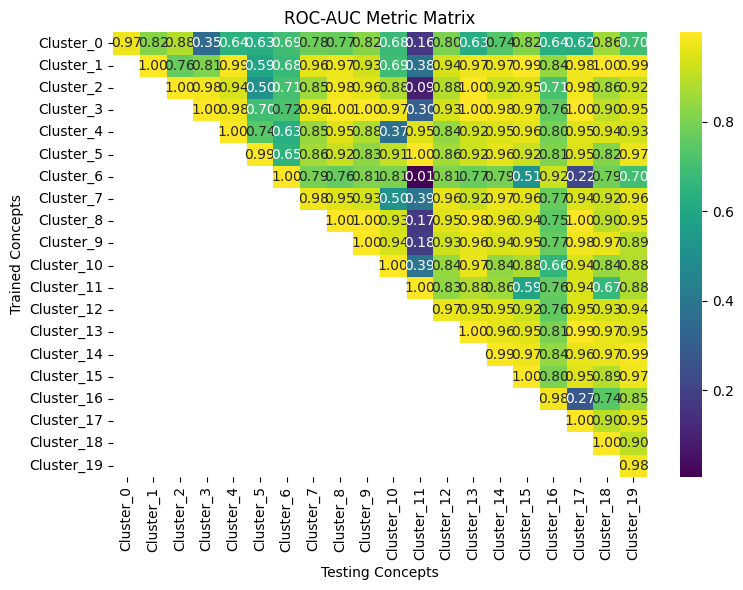

In [45]:
# Visualize the ROC-AUC metric matrix
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load results
with open("output-strategy1.json", "r") as f:
    results = json.load(f)

key_metric = results["concept_metric_callback_ROC-AUC"]["metrics"]
print(key_metric)

# Locate the metric callback entry
metric_key = next(k for k in results if k.startswith("concept_metric_callback"))
metric_data = results[metric_key]

# Extract concepts order and metric matrix
concepts = metric_data["concepts_order"]
matrix = metric_data["metric_matrix"]

# Build DataFrame
df = pd.DataFrame(matrix, index=concepts, columns=concepts)
df = df.where(np.triu(np.ones(df.shape), k=0).astype(bool))
# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df, annot=True, fmt=".2f", cmap="viridis")
plt.title("ROC-AUC Metric Matrix")
plt.ylabel("Trained Concepts")
plt.xlabel("Testing Concepts")
plt.tight_layout()
plt.show()


Let's recreate the model and select another strategy to compare the results with the previous experiment. This will help you understand how different strategies affect the performance of the model on the same dataset.

In [46]:
# model =  IsolationForestAdapter()
# model = LocalOutlierFactorAdapter()  # Use the same model as before

Select a different strategy to compare the results with the previous experiment.

In [47]:
strategy = ReplayEnhancedStrategy(
    model,
    AdaptiveBalancedReplayBuffer(selection_method=RandomSelection(), max_size=3000),
)
# Replace with your strategy, e.g., `CumulativeStrategy(model)`


 Now, let's run the experiment again with the new strategy. The results will be saved in `output-strategy2.json` file.

In [48]:
# Run the experiment
callbacks = [
    ConceptMetricCallback(
        base_metric=RocAuc(),
        metrics=[ContinualAverage(), BackwardTransfer(), ForwardTransfer()],
    ),
    TimeEvaluationCallback(),
    MemoryUsageCallback(),
]
scenario = ConceptAwareScenario(dataset, strategy=strategy, callbacks=callbacks)
scenario.run()

output_writer = JsonOutputWriter(pathlib.Path("output-strategy2.json"))
output_writer.write([model, dataset, strategy, *callbacks])

{'ContinualAverage': 0.9519536405205038, 'BackwardTransfer': -0.003996216199781746, 'ForwardTransfer': 0.9025168405335561}


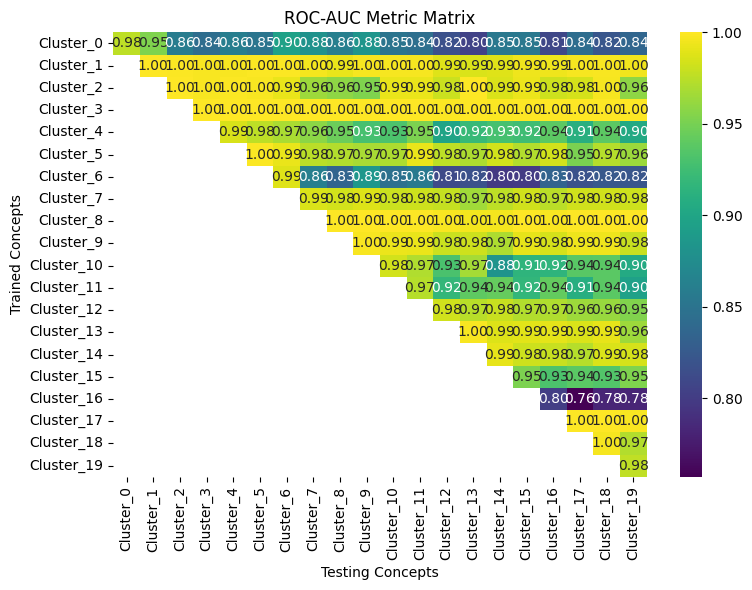

In [49]:
# Visualize the ROC-AUC metric matrix
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load results
with open("output-strategy2.json", "r") as f:
    results = json.load(f)

key_metric = results["concept_metric_callback_ROC-AUC"]["metrics"]
print(key_metric)

# Locate the metric callback entry
metric_key = next(k for k in results if k.startswith("concept_metric_callback"))
metric_data = results[metric_key]

# Extract concepts order and metric matrix
concepts = metric_data["concepts_order"]
matrix = metric_data["metric_matrix"]

# Build DataFrame
df = pd.DataFrame(matrix, index=concepts, columns=concepts)

df = df.where(np.triu(np.ones(df.shape), k=0).astype(bool))
# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df, annot=True, fmt=".2f", cmap="viridis")
plt.title("ROC-AUC Metric Matrix")
plt.ylabel("Trained Concepts")
plt.xlabel("Testing Concepts")
plt.tight_layout()
plt.show()


{'ContinualAverage': 0.9543831085518032, 'BackwardTransfer': -0.0035618040286663224, 'ForwardTransfer': 0.8866879915613944}


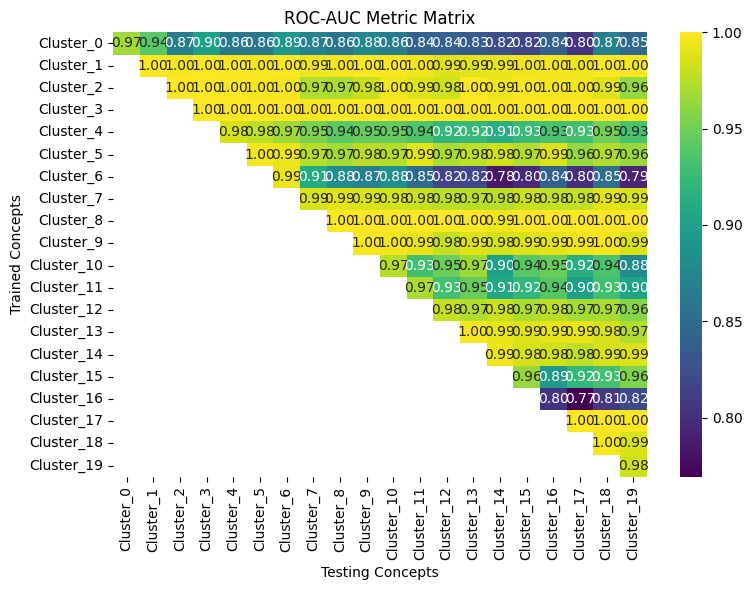

In [50]:
# test of ReservoirSamplingStrategy
from pyclad.strategies.replay.reservoir import BalancedReservoirSamplingStrategy

strategy = BalancedReservoirSamplingStrategy(
    model,
    max_buffer_size=3000
)

# Run the experiment
callbacks = [
    ConceptMetricCallback(
        base_metric=RocAuc(),
        metrics=[ContinualAverage(), BackwardTransfer(), ForwardTransfer()],
    ),
    TimeEvaluationCallback(),
]
scenario = ConceptAwareScenario(dataset=dataset, strategy=strategy, callbacks=callbacks)
scenario.run()

output_writer = JsonOutputWriter(pathlib.Path("output-reservoir-unsw-cr.json"))
output_writer.write([model, dataset, strategy, *callbacks]) 

# Load results
with open("output-reservoir-unsw-cr.json", "r") as f:
    results = json.load(f)

key_metric = results["concept_metric_callback_ROC-AUC"]["metrics"]
print(key_metric)

# Locate the metric callback entry
metric_key = next(k for k in results if k.startswith("concept_metric_callback"))
metric_data = results[metric_key]

# Extract concepts order and metric matrix
concepts = metric_data["concepts_order"]
matrix = metric_data["metric_matrix"]

# Build DataFrame
df = pd.DataFrame(matrix, index=concepts, columns=concepts)

# keep only the upper triangle of the matrix, including the diagonal
df = df.where(np.triu(np.ones(df.shape), k=0).astype(bool))

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df, annot=True, fmt=".2f", cmap="viridis")
plt.title("ROC-AUC Metric Matrix")
plt.ylabel("Trained Concepts")
plt.xlabel("Testing Concepts")
plt.tight_layout()
plt.show()


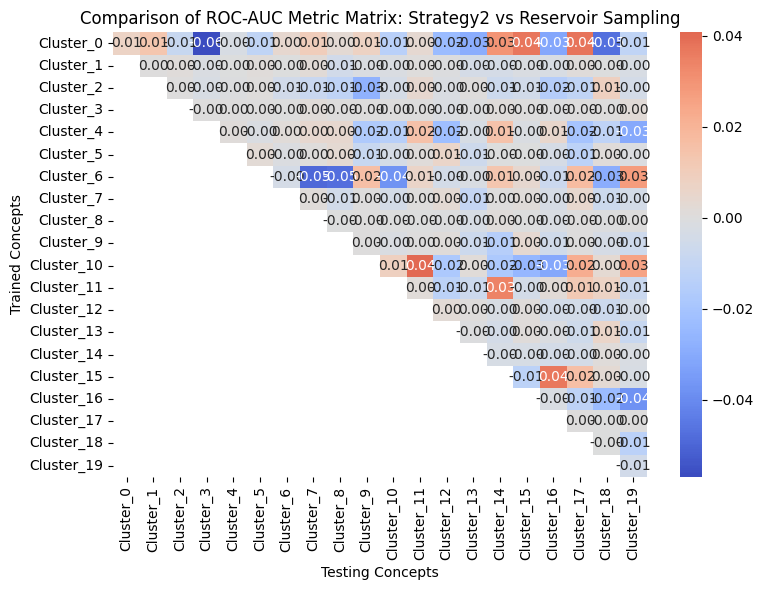

In [51]:
# analyze the results in output-reservoir-unsw-cr.json and output-strategy2.json, cpomare the results, highlight the lower scores in reservoir sampling

# Visualize the ROC-AUC metric matrix for strategy2

# Load results
f = open("output-strategy2.json", "r")
results = json.load(f)
metric_key = next(k for k in results if k.startswith("concept_metric_callback"))
metric_data = results[metric_key]
# Extract concepts order and metric matrix
concepts = metric_data["concepts_order"]
matrix = metric_data["metric_matrix"]
# Build DataFrame
df_strategy2 = pd.DataFrame(matrix, index=concepts, columns=concepts)
f.close()

# Visualize the ROC-AUC metric matrix for reservoir sampling
f = open("output-reservoir-unsw-cr.json", "r")
results = json.load(f)
metric_key = next(k for k in results if k.startswith("concept_metric_callback"))
metric_data = results[metric_key]
# Extract concepts order and metric matrix
concepts = metric_data["concepts_order"]
matrix = metric_data["metric_matrix"]
# Build DataFrame
df_reservoir = pd.DataFrame(matrix, index=concepts, columns=concepts
)
f.close()

# Compare the two DataFrames
comparison_df = df_strategy2 - df_reservoir
# Plot heatmap for the comparison, keep the top right triangle only, including the diagonal
comparison_df = comparison_df.where(np.triu(np.ones(comparison_df.shape), k=0).astype(bool))
plt.figure(figsize=(8, 6))
sns.heatmap(comparison_df, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Comparison of ROC-AUC Metric Matrix: Strategy2 vs Reservoir Sampling")
plt.ylabel("Trained Concepts")
plt.xlabel("Testing Concepts")
plt.tight_layout()
plt.show()


You can analyze the results from both experiments by inspecting the output files (`output-strategy1.json` and `output-strategy2.json`). This will help you understand how different strategies affect the performance of the model on the same dataset. You can focus on the summarized metrics such as `ContinualAverage`, `BackwardTransfer`, and `ForwardTransfer` to compare the performance of the model across different strategies. You can find them in the `concept_metric_callback_ROC-AUC` -> `metrics` section of the output files.

# Extend the `pyCLAD` library :)
You can try the `pyCLAD` library with your own datasets and models. The library is designed to be flexible and extensible, allowing you to adapt it to your specific needs. You can also contribute to the library by implementing new models, strategies, or datasets. Check out the [documentation](https://pyclad.readthedocs.io/en/latest/) for more information on how to get started.